In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os
import shutil

In [2]:
base_dir=r'./icebergAndship'

In [3]:
#if not os.path.isdir(base_dir):
    #os.mkdir(base_dir)
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
os.mkdir(train_dir)
os.mkdir(test_dir)

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './icebergAndship\\train'

In [4]:
labels=['Iceberg','Ship']
data=['train','test']
for train_or_test in data:
    for i in labels:
        os.mkdir(os.path.join(base_dir,train_or_test,i))

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './icebergAndship\\train\\Iceberg'

In [5]:
image_dir=r'./output_images'

In [6]:
for j,img in enumerate(os.listdir(image_dir)):
    for spec in ['Iceberg','Ship']:
        if spec in img:
            s=os.path.join(image_dir,img)
            if j%5==0:
                d=os.path.join(base_dir,'test',spec,img)
            else:
                d=os.path.join(base_dir,'train',spec,img)
            shutil.copy(s,d)

In [7]:
from torchvision import transforms

In [8]:
transform=transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
train_ds=torchvision.datasets.ImageFolder(
    train_dir,
    transform=transform
)
test_ds=torchvision.datasets.ImageFolder(
    test_dir,
    transform=transform
)
BATCHSIZE=16
train_dl=torch.utils.data.DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True
)

test_dl=torch.utils.data.DataLoader(
    test_ds,
    batch_size=16
)

In [9]:
imgs,label=next(iter(train_dl))
imgs.shape

torch.Size([16, 3, 96, 96])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,16,3)
        self.conv2=nn.Conv2d(16,32,3)
        self.conv3=nn.Conv2d(32,64,3)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*10*10,1024)
        self.fc2=nn.Linear(1024,256)
        self.fc3=nn.Linear(256,2)
        self.drop=nn.Dropout()
        self.bn1=nn.BatchNorm2d(16)
        self.bn2=nn.BatchNorm2d(32)
        self.bn3=nn.BatchNorm2d(64)
        self.bn_f1=nn.BatchNorm1d(1024)
        self.bn_f2=nn.BatchNorm1d(256)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.bn1(x)
        x=self.pool(F.relu(self.conv2(x)))
        x=self.bn2(x)
        x=self.pool(F.relu(self.conv3(x)))
        x=self.bn3(x)
        x=x.view(-1,x.size(1)*x.size(2)*x.size(3))
        x=F.relu(self.fc1(x))
        x=self.bn_f1(x)
        x=self.drop(x)
        x=F.relu(self.fc2(x))
        x=self.bn_f2(x)
        x=self.drop(x)
        x=self.fc3(x)
        return x

In [11]:
model=Net()

In [12]:
preds=model(imgs)

In [13]:
if torch.cuda.is_available():
    model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [15]:
epochs=30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.545 accuracy: 0.739 test_loss：  0.443 test_accuracy: 0.788
epoch:  1 loss：  0.482 accuracy: 0.784 test_loss：  0.404 test_accuracy: 0.841
epoch:  2 loss：  0.429 accuracy: 0.802 test_loss：  0.385 test_accuracy: 0.841
epoch:  3 loss：  0.376 accuracy: 0.829 test_loss：  0.318 test_accuracy: 0.847
epoch:  4 loss：  0.383 accuracy: 0.829 test_loss：  0.497 test_accuracy: 0.726
epoch:  5 loss：  0.411 accuracy: 0.798 test_loss：  0.34 test_accuracy: 0.847
epoch:  6 loss：  0.31 accuracy: 0.861 test_loss：  0.355 test_accuracy: 0.847
epoch:  7 loss：  0.29 accuracy: 0.867 test_loss：  0.43 test_accuracy: 0.816
epoch:  8 loss：  0.261 accuracy: 0.892 test_loss：  0.467 test_accuracy: 0.813
epoch:  9 loss：  0.236 accuracy: 0.914 test_loss：  0.373 test_accuracy: 0.838
epoch:  10 loss：  0.163 accuracy: 0.941 test_loss：  0.523 test_accuracy: 0.863
epoch:  11 loss：  0.209 accuracy: 0.92 test_loss：  0.415 test_accuracy: 0.847
epoch:  12 loss：  0.096 accuracy: 0.96 test_loss：  0.493 test_accur

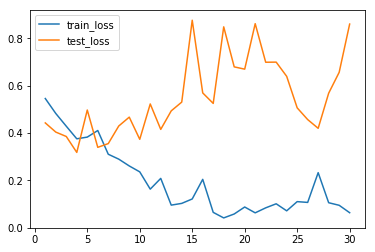

In [16]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

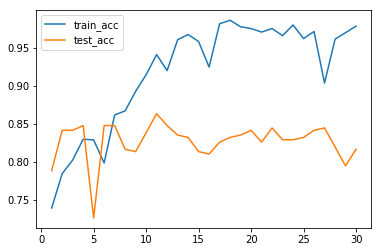

In [17]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()